#### Урок 8.
Python применение статистических критериев на практике - пайплайн оценки A/B

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from statsmodels.stats.power import TTestIndPower

In [2]:
df = pd.read_excel('./AB_Test_Results (2).xlsx')
df.head(10)

C:\Users\Лина\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
5,2380,variant,0.0
6,2849,control,0.0
7,9168,control,0.0
8,6205,variant,0.0
9,7548,control,0.0


In [3]:
# Проведем первичное исследование данных. Посмотрим нет ли пропущенных значений.
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [4]:
# Посмотрим есть ли пропущенные значения
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

In [5]:
# Посмотрим количество уникальных значений.
df.nunique()

USER_ID         6324
VARIANT_NAME       2
REVENUE          101
dtype: int64

Предварительные выводы.
У нас достаточно полное заполнение данных, пропушенных строк нет. У нас нет даннных о критериях системы сплитования и результатов A-A тестов, потому исходя только из количественных показателей в предоставленных данных = мы можем сделать вывод что выборки распределены относиельно равномерно.
Количество уникальных пользовтаелей меньше общих показаелей посещений сайта, потому мы можем сделать вывод что данные это фиксация всех посещений сайта и один и тот же пользователь мог регистрироваться системой сбора даннных несколько раз.
Так как перед нами стоит задача оценить результаты AB теста, то будем оценивать все данные. 


In [6]:
# Проверим распределение данных на нормальность по основной метрике.

alpha = 0.05

st = shapiro(df.REVENUE)
print('Распределенние {}нормально\n'.format( {True:'не ', False:''}[st[1] < alpha]));

Распределенние не нормально



C:\Users\Лина\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


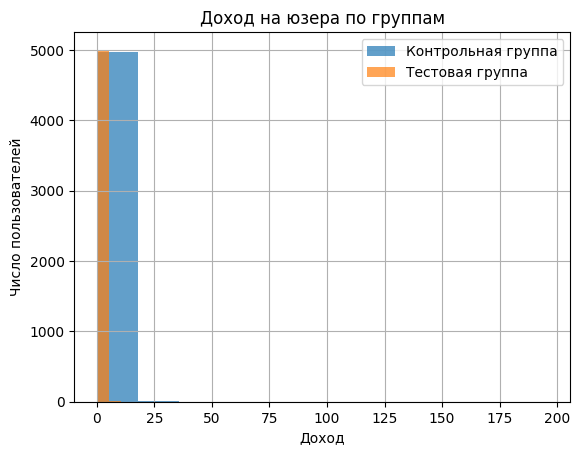

In [7]:
# Построим гистограммы

control = df.query('VARIANT_NAME == "control"')
test = df.query('VARIANT_NAME == "variant"')

control.REVENUE.hist(bins = 11, alpha =0.7, label='Контрольная группа')
test.REVENUE.hist(bins = 11, alpha =0.7, label='Тестовая группа')
plt.title('Доход на юзера по группам')
plt.xlabel('Доход')
plt.ylabel('Число пользователей')
plt.legend();

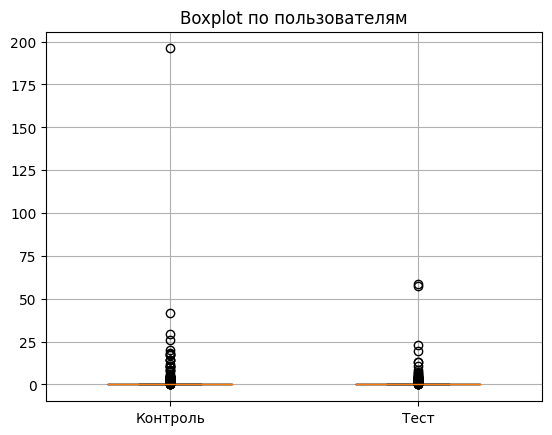

In [8]:
plt.boxplot([control.REVENUE,test.REVENUE],
            labels=['Контроль','Тест'],
            widths=0.5
           )
plt.title('Boxplot по пользователям',  loc='center')
plt.grid(axis  ='both')

Мы видим некорректное распределение данных по ключевой метрики. Пользователей совершивших покупку (данные из df.nunique) всего 101 из 10000, то есть около 1%. Потому каждое такое действие выглядит как выброс на гистограмме.

In [9]:
# Так как у нас нет нормального распределения для оценки статзначимости используем критерий Манна Уитни. 

stats.mannwhitneyu(x=control.REVENUE.values, y = test.REVENUE.values)

MannwhitneyuResult(statistic=12521564.0, pvalue=0.47825247965294926)

In [10]:
# При больших выборках распределение стремится к нормальному. Потому проведем двухвыборочный t-тест
stats.ttest_ind(control.REVENUE.values, test.REVENUE.values, equal_var = False)

Ttest_indResult(statistic=1.268403803110966, pvalue=0.20469713432410774)

В обоих тестах p-value больше альфы 0.05. Потому стат значимых различий между выборками нет.

In [11]:
# Расчитаем мощность теста.

C_mean = control.REVENUE.values.mean()
T_mean = test.REVENUE.values.mean()
C_std = control.REVENUE.values.std()
T_std = test.REVENUE.values.std()
n = len(control.REVENUE.values)     
S = np.sqrt((T_std**2 +C_std**2)/2)     
ef = float((C_mean-T_mean)/S)
alpha = 0.05
analysis = TTestIndPower()
result = analysis.solve_power(ef, power=None, nobs1=n, ratio=1.0, alpha=alpha)
result

0.24502831099016653

### Выводы. 
Между предоставленными выборками нет стат значимых различий. Внедрять тестируемое решение нет смысла. 
Анализ предоставленных данных показывает что для выбранного AB теста подобраны не самые актуальные параметры и метрики. Рекомендуется проработать гипотезы и настроить систему сплитования пользоватлей и систему сбора данных.  
